# Hate Speech Recognition using AI

This notebook consists the code for the development of a Hate Speech Recognition using AI. The data used for this project is Hate Speech dataset taken from Kaggle: https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset.

The notebook includes:

*   Exploratory Data Analysis
*   Data Cleaning and Preperation
*   Feature Generation
*   Model Development
*   Evaluation

# Set-Up

The noteboook ensures that all the libraries needed to execute the code are installed. Kaggle aAPI token is needed to download the data from the website.

In [2]:
!pip install kaggle

In [3]:
# Upload Kaggle API token: generate it through the kaggle account
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"b1d9a154ac61407aa981","key":"eebe0bdd7e7eda464670a241866e9455"}'}

In [4]:
# Ensure the kaggle.json is in the right folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download the dataset from Kaggle
!kaggle datasets download -d mrmorj/hate-speech-and-offensive-language-dataset

Dataset URL: https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset
License(s): CC0-1.0
  0% 0.00/1.01M [00:00<?, ?B/s]
100% 1.01M/1.01M [00:00<00:00, 33.3MB/s]


In [6]:
# Unzip the downloaded dataset
!unzip hate-speech-and-offensive-language-dataset.zip

Archive:  hate-speech-and-offensive-language-dataset.zip
  inflating: labeled_data.csv        


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Exploratory Data Analysis

Goal: Check for null values, understand the structure, and inspect the data distribution.


In [8]:
df = pd.read_csv('labeled_data.csv')

In [9]:
print("Shape of the dataset:", df.shape)


Shape of the dataset: (24783, 7)


In [10]:
print("\nFirst 5 rows of the dataset:\n", df.head())



First 5 rows of the dataset:
    Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


The dataset has 7 columns where the **class column** labels the tweet as **hate speech(represented as 0), offensive language(represented as 1) and neither(represented as 2)**.

The tweet columns shows the actaul texts for the tweet. The text contains special chafracters such as exclamation marks, 'RT'; acronym for retweet. This is helpful information during the data cleaning process.

In [11]:
print("\nData types and null values:\n", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB

Data types and null values:
 None


In [12]:

# Check for missing values
print("\nMissing values in each column:\n", df.isnull().sum())


Missing values in each column:
 Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64



Class distribution:
 class
1    19190
2     4163
0     1430
Name: count, dtype: int64


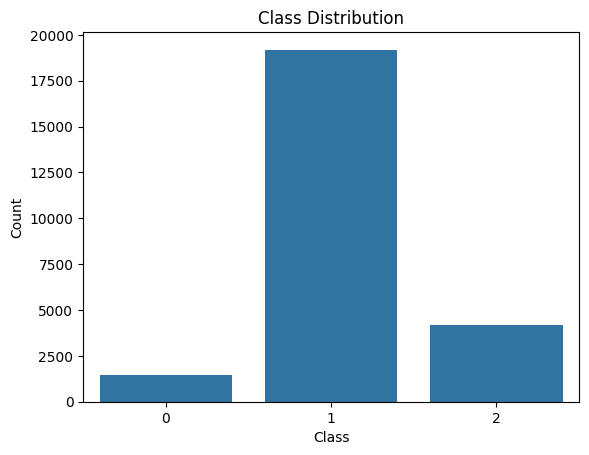

In [13]:
# distribution of classes
print("\nClass distribution:\n", df['class'].value_counts())

# Visualize the class distribution
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

This shows that the dataset is unbalanced with a bias towards the label '1' or the offensive language tweets.

To mitigate this, the data can be augmented with simulated data or additional datasets. Equally we could try usingh SMOTE to address the imbalance in the dataset.

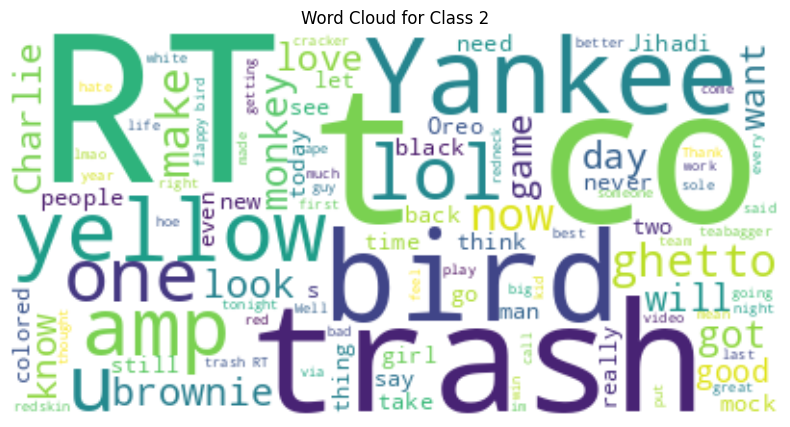

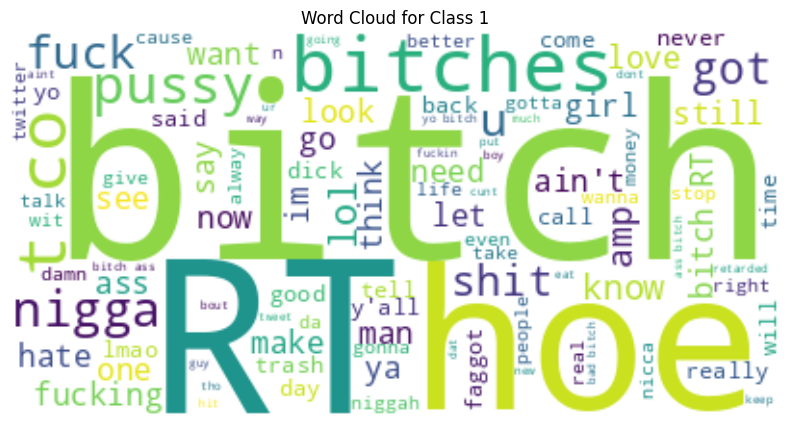

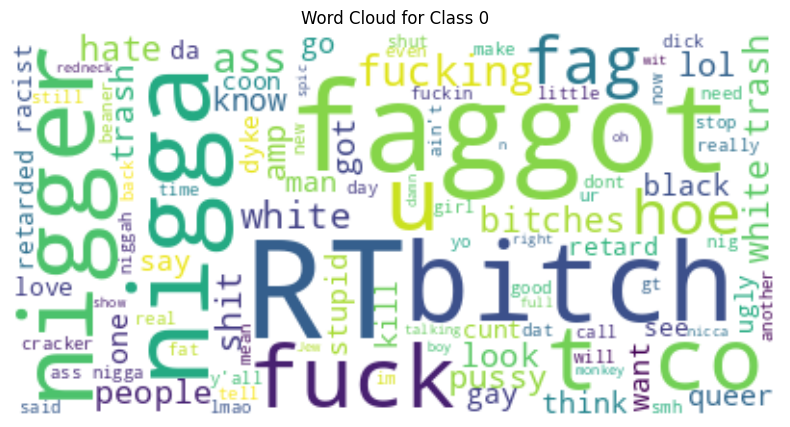

In [14]:
#  Text Data Visualization
# Generate a word cloud for each class
def plot_wordcloud(class_label):
    text = " ".join(review for review in df[df['class'] == class_label].tweet)
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for Class {class_label}')
    plt.show()

for class_label in df['class'].unique():
    plot_wordcloud(class_label)


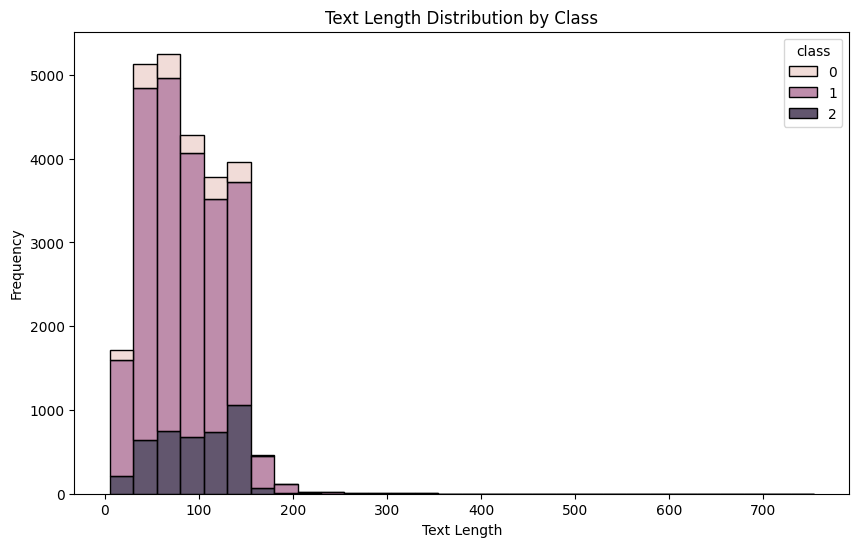

In [15]:
# Text Length Analysis
# Add a new column for text length
df['text_length'] = df['tweet'].apply(len)

# Plot the distribution of text length for each class
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='class', multiple='stack', bins=30)
plt.title('Text Length Distribution by Class')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# 2. Data Pre-Processing

- Clean the text data: Remove special characters, stop words, and perform tokenization.
- Convert text to lowercase, handle contractions, and perform stemming or lemmatization.

In [18]:
import re

def clean_text(text):

  # Remove special characters
  text = re.sub(r"@\S+|https?:\S+|[^A-Za-z0-9]+", " ", text)

  # Convert to lowercase
  text = text.lower()

  # Remove stop words
  stop_words = set(stopwords.words("english"))
  words = [word for word in text.split() if word not in stop_words]

  # Join the words back into a string
  cleaned_text = " ".join(words)

  return cleaned_text


In [20]:
# drop all columns except tweet and class
df = df.drop(['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)

df['clean_tweet'] = df['tweet'].apply(clean_text)

df.head()

,Unnamed: 0,class,tweet,text_length,clean_tweet
0,0,2,!!! RT @mayasolovely: As a woman you shouldn't...,140,rt mayasolovely woman complain cleaning house ...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,85,rt mleew17 boy dats cold tyga dwn bad cuffin d...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,120,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,62,rt c g anderson viva based look like tranny
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137,rt shenikaroberts shit hear might true might f...


<ipython-input-22-e64a9a153364>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


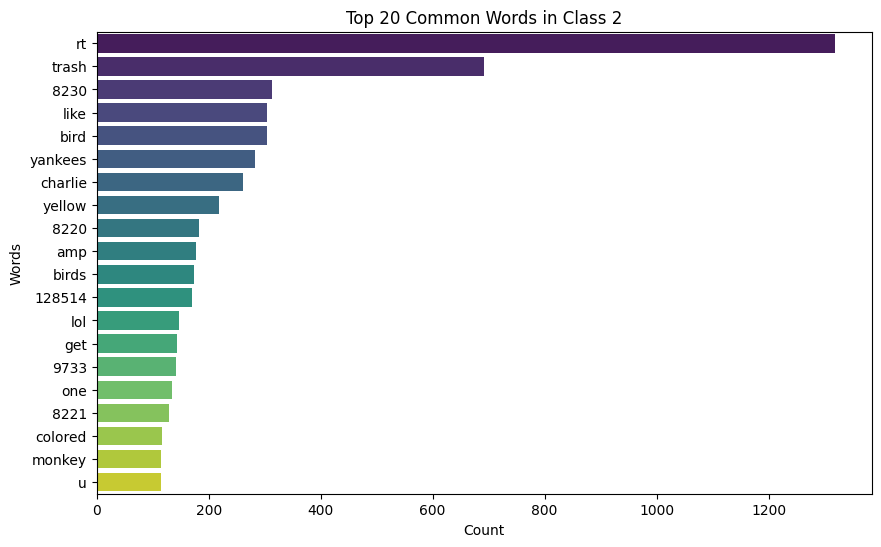

<ipython-input-22-e64a9a153364>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


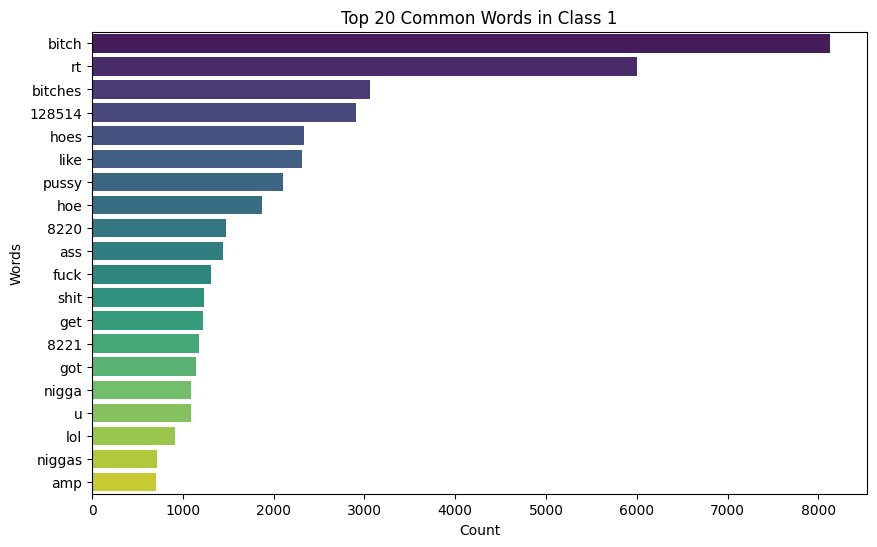

<ipython-input-22-e64a9a153364>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


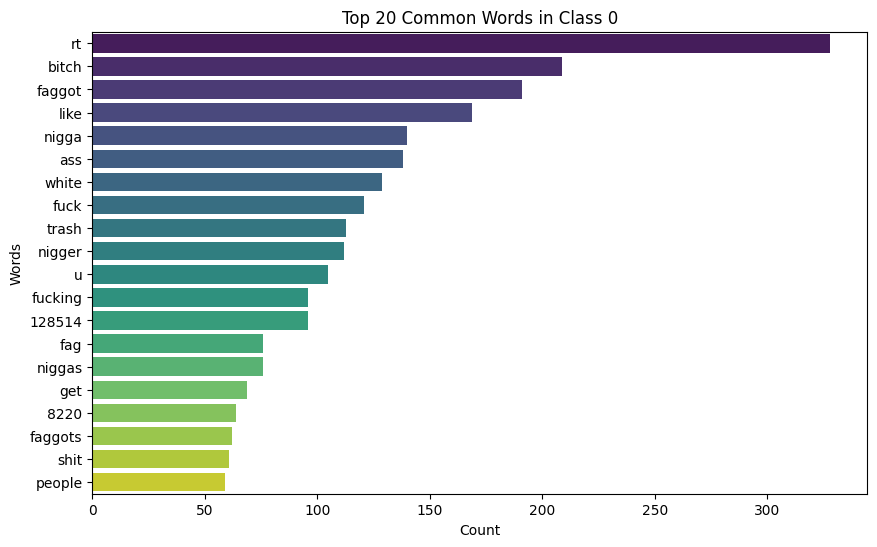

In [22]:
#  Common Words Analysis
# Function to get common words in each class

stop = set(stopwords.words('english'))

def get_common_words(class_label, n=20):
    text = " ".join(review for review in df[df['class'] == class_label].clean_tweet)
    words = [word for word in text.split() if word.lower() not in stop]
    common_words = Counter(words).most_common(n)
    return common_words

# for class_label in df['class'].unique():
#     common_words = get_common_words(class_label)
#     print(f"\nCommon words in Class {class_label}:\n", common_words)

# Function to plot common words
def plot_common_words(common_words, class_label):
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(f'Top {len(common_words)} Common Words in Class {class_label}')
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.show()

# Apply the functions and plot
for class_label in df['class'].unique():
    common_words = get_common_words(class_label)
    plot_common_words(common_words, class_label)